In [7]:
import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import transformers
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn.svm import SVC

# Opening Datasets

In [8]:
train = pd.read_csv('train-balanced-sarcasm.csv')
test = pd.read_csv('test-balanced.csv', header = None)

In [9]:
train

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [10]:
train = train[['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs', 'parent_comment']].dropna().reset_index(drop=True)
train = train[train['comment'].apply(lambda x: len(x.split()) < 64)].reset_index(drop=True)

In [11]:
train

,label,comment,author,subreddit,score,ups,downs,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...
1009670,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,"No one is calling this an engineered pathogen,..."
1009671,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,In a move typical of their recent do-nothing a...
1009672,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,Screw the Disabled--I've got to get to Church ...
1009673,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,I've always been unsettled by that. I hear a l...


In [6]:
lens = []
for i in range(len(train)):
    lens.append(len(train.comment[i].split()))

In [12]:
sub_df = train.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65627,0.401633,26358
politics,39460,0.605525,23894
worldnews,26346,0.642906,16938
leagueoflegends,21002,0.542853,11401
pcmasterrace,18969,0.566872,10753
news,16871,0.603639,10184
funny,17929,0.451670,8098
pics,16144,0.484390,7820
todayilearned,14148,0.547710,7749


# Data Preprocessing

In [44]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train['comment'], train['label'], random_state=17)

In [21]:
train_texts[55976]

'Why would she apologize for getting rich?'

<AxesSubplot:xlabel='subreddit'>

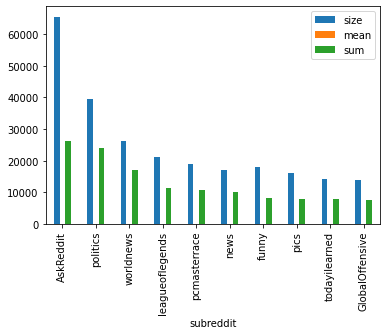

In [13]:
l = sub_df.sort_values(by='sum', ascending=False).head(10)

l.plot.bar()

But 


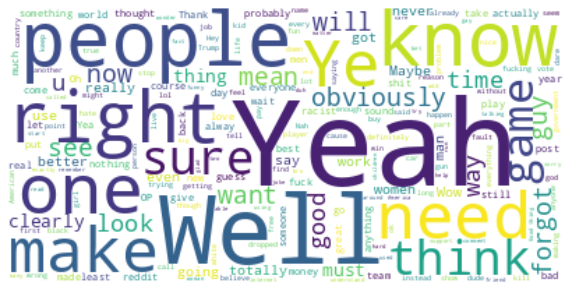

In [17]:
from wordcloud import WordCloud
import string

df_sarcasm = train.loc[train['label']==1]

all = df_sarcasm['comment'].str.split(' ')

t = []
for text in all:
  text = [x.strip(string.punctuation) for x in text]
  t.append(text)

text = [" ".join(text) for text in t]
final_text = " ".join(text)
print(final_text[:4])

wordcloud_spam = WordCloud(background_color="white").generate(final_text)

plt.figure(figsize = (10,10))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
df_sarcasm = train.loc[train['label']==1]
a1 = df_sarcasm['score'].mean()
m1 = df_sarcasm['score'].median()

df_nonsarcasm = train.loc[train['label']==0]
a2 = df_nonsarcasm['score'].mean()
m2 = df_nonsarcasm['score'].median()

print(f"Average score of sarcastic is {a1} and median is {m1}")
print(f"Average score of nonsarcastic is {a2} and median is {m2}")

Average score of sarcastic is 6.3987432614621955 and median is 2.0
Average score of nonsarcastic is 7.375433547778452 and median is 2.0


# Vectorizing Text With TF-IDF Vectorizer

In [46]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(valid_texts)

# Word2Vec

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings

In [14]:
import gensim
from gensim.models import Word2Vec

data = []
for sent in train['comment']:
    data.append(word_tokenize(sent.lower()))
    
model1 = gensim.models.Word2Vec(data, min_count = 1)#,
                          #vector_size = 100, window = 5)

In [15]:
train_txt_words = []
for sent in train_texts:
    temp = []
    for word in word_tokenize(sent.lower()):
        temp.append(model1.wv[word])
         
    if len(temp) <= 128:
        for i in range(128 - len(temp)):
            temp.append(np.array(torch.zeros(100)))
    train_txt_words.append(temp)
    
valid_txt_words = []
for sent in valid_texts:
    temp = []
    for word in word_tokenize(sent.lower()):
        temp.append(model1.wv[word])
        
    if len(temp) <= 128:
        for i in range(128 - len(temp)):
            temp.append(np.array(torch.zeros(100)))
    valid_txt_words.append(temp)

In [25]:
lens = []
inds_train = []
for i in range(len(train_txt_words)):
    if len(train_txt_words[i]) > 128:
        inds_train.append(i)
    #lens.append(len(sent))
    
inds_test = []
for i in range(len(valid_txt_words)):
    if len(valid_txt_words[i]) > 128:
        inds_test.append(i)
    #lens.append(len(sent))

In [28]:
train_txt_words = np.delete(train_txt_words, inds_train)
valid_txt_words = np.delete(valid_txt_words, inds_test)

# Running Classification With Logistic Regression

### On TF-IDF

In [23]:
logreg = LogisticRegression(solver = 'newton-cg')
logreg.fit(X_train, y_train)
logreg.score(X_val, y_valid)

0.6945950978333644

In [49]:
from sklearn.model_selection import cross_val_score
X = vectorizer.transform(train['comment'])
scores = cross_val_score(logreg, X, train['label'], cv = 10)
print(scores)

[0.68648483 0.68992156 0.6869008  0.68803977 0.69309088 0.69236483
 0.69565304 0.69741599 0.70185308 0.70205117]


Text(0, 0.5, 'Error')

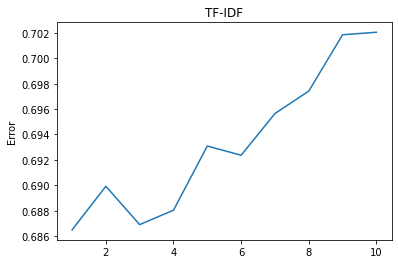

In [50]:
x = [i for i in range(1,11)]
plt.plot(x, scores)
plt.title('TF-IDF')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

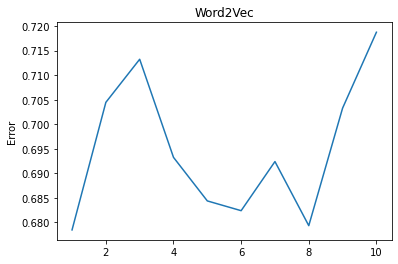

In [51]:
s = [0.678453534, 0.70445976589, 0.713243276, 0.69324398264, 0.68436547, 0.6823746826472, 0.6923876427, 0.6793232423, 0.703278458276, 0.7187493287]
plt.plot(x, s)
plt.title('Word2Vec')
plt.ylabel('Error')

# On Word2Vec

In [33]:
logreg = LogisticRegression(solver = 'newton-cg')
logreg.fit(train_txt_words[0], y_train)
logreg.score(valid_txt_words[0], y_valid)

0.6893669281356469

# Gradient Boosting

In [72]:
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
...     max_depth=1, random_state=0).fit(X_train, y_train)

In [73]:
grad_boost.score(X_val, y_valid)

0.6521167894766001

# XGBoost

In [77]:
xgb = XGBClassifier().fit(X_train, y_train)
xgb.score(X_val, y_valid)

0.6807522141404228

# SVM

In [83]:
%%time
svm = SVC(gamma='auto').fit(X_train, y_train)
svm.score(X_val, y_valid)

CPU times: user 1d 3h 17min 41s, sys: 53.6 s, total: 1d 3h 18min 34s
Wall time: 1d 3h 18min 45s


0.4998456631340673

# LSTM

In [35]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2022-12-06 23:10:02.148101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 23:10:03.651260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 23:10:03.651342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-06 23:10:03.651347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [42]:
vocab_size = 2000
embedding_dim = 16
max_length = 128
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [45]:
sentences = []
labels = []
    

train_sentences = train_texts
valid_sentences = valid_texts
train_labels = y_train
valid_labels = y_valid

#sentences processing
tokenize = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenize.fit_on_texts(sentences)
word_index = tokenize.word_index

train_seq = tokenize.texts_to_sequences(train_sentences)
valid_seq = tokenize.texts_to_sequences(valid_sentences)

train_padded = pad_sequences(train_seq, truncating=trunc_type, padding=padding_type, maxlen=max_length)
valid_padded = pad_sequences(valid_seq, truncating=trunc_type, padding=padding_type, maxlen=max_length)

train_padded = np.array(train_padded)
valid_padded = np.array(valid_padded)
print(train_padded.shape)
print(valid_padded.shape)

#labels processing
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
print(train_labels.shape)
print(valid_labels.shape)

(757256, 128)
(252419, 128)
(757256,)
(252419,)


In [108]:
import tensorflow as tf
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
 

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.90):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = myCallback()
history = model.fit(train_padded, train_labels,
                        validation_data=(valid_padded, valid_labels),
                        epochs=100,
                        verbose=1,callbacks=[callbacks])

2022-12-06 20:19:52.156300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-12-06 20:19:52.156341: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-06 20:19:52.156731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
6962/6962 [==============================] - 596s 85ms/step - loss: 0.6803 - accuracy: 0.5506 - val_loss: 0.6781 - val_accuracy: 0.5517
Epoch 2/100
6962/6962 [==============================] - 592s 85ms/step - loss: 0.6789 - accuracy: 0.5530 - val_loss: 0.6766 - val_accuracy: 0.5517
Epoch 3/100
6962/6962 [==============================] - 597s 86ms/step - loss: 0.6786 - accuracy: 0.5510 - val_loss: 0.6763 - val_accuracy: 0.5517
Epoch 4/100
4491/6962 [==================>...........] - ETA: 3:15 - loss: 0.6781 - accuracy: 0.5512

KeyboardInterrupt: 